In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['chest_xray', 'vgg16']


If we want **REPRODUCIBLE** results:

In [2]:
# If we want to make out results REPRODUCIBLE, we can set the parameters below to increase reproducibility:
os.environ['PYTHONHASHSEED'] = '0' # Set the seed for hash based operations in python
np.random.seed(111) # Set the numpy seed
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) # Disable multi-threading in tensorflow ops
tf.compat.v1.set_random_seed(111) # Set the random seed in tensorflow at graph level
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf) # Define a tensorflow session with the session configs set above
K.set_session(sess) # Set the session in keras
aug.seed(111) # Make the augmentation sequence deterministic

The dataset has 3 dirs: train, validation and test:

In [3]:
# Define path to the data directory
data_dir = Path('./input/chest_xray/')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

## Dataset check

Genaral check of the training dataset.
There are 2 subdirectories: NORMAL and PNEUMONIA

In [4]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images:
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = [] # list for (img_path, label) format

for img in normal_cases:
    train_data.append((img,0))      # labeling NORMAL as 0

for img in pneumonia_cases:
    train_data.append((img, 1))     # labeling PNEUMONIA as 1

# making it into dataframe:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)        # so it stores image addresses and labels

# shuffling the data: 
train_data = train_data.sample(frac=1.).reset_index(drop=True)      # fraction = 1 = 100%

train_data.head()

,image,label
0,input\chest_xray\train\NORMAL\NORMAL2-IM-0454-...,0
1,input\chest_xray\train\NORMAL\NORMAL2-IM-1252-...,0
2,input\chest_xray\train\PNEUMONIA\person1233_vi...,1
3,input\chest_xray\train\PNEUMONIA\person1312_ba...,1
4,input\chest_xray\train\PNEUMONIA\person446_vir...,1


label
1    3875
0    1341
Name: count, dtype: int64


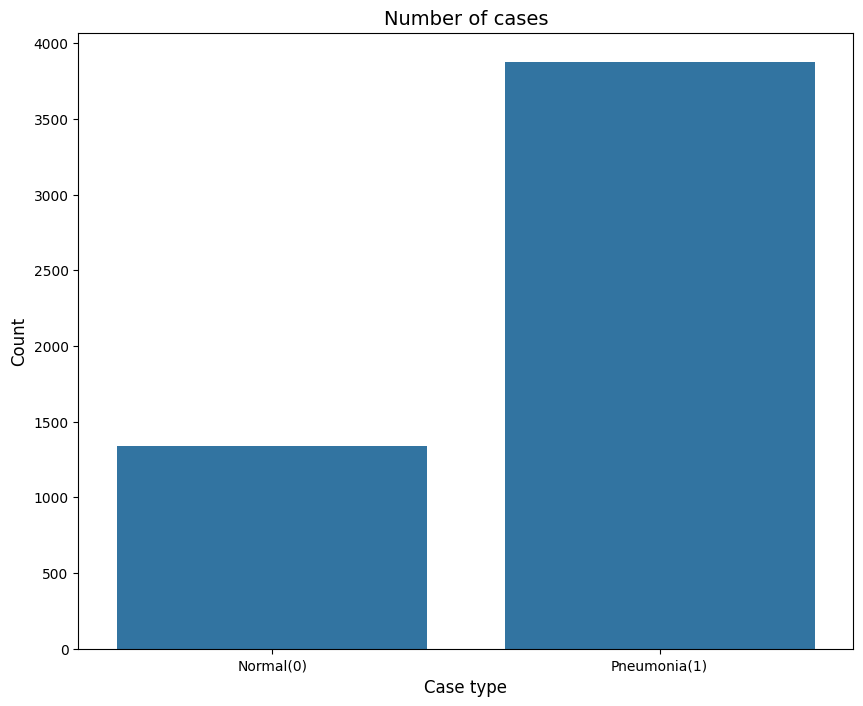

In [5]:
# Let's check the difference in number of samples in each category.

cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

The data is IMBALANCED.

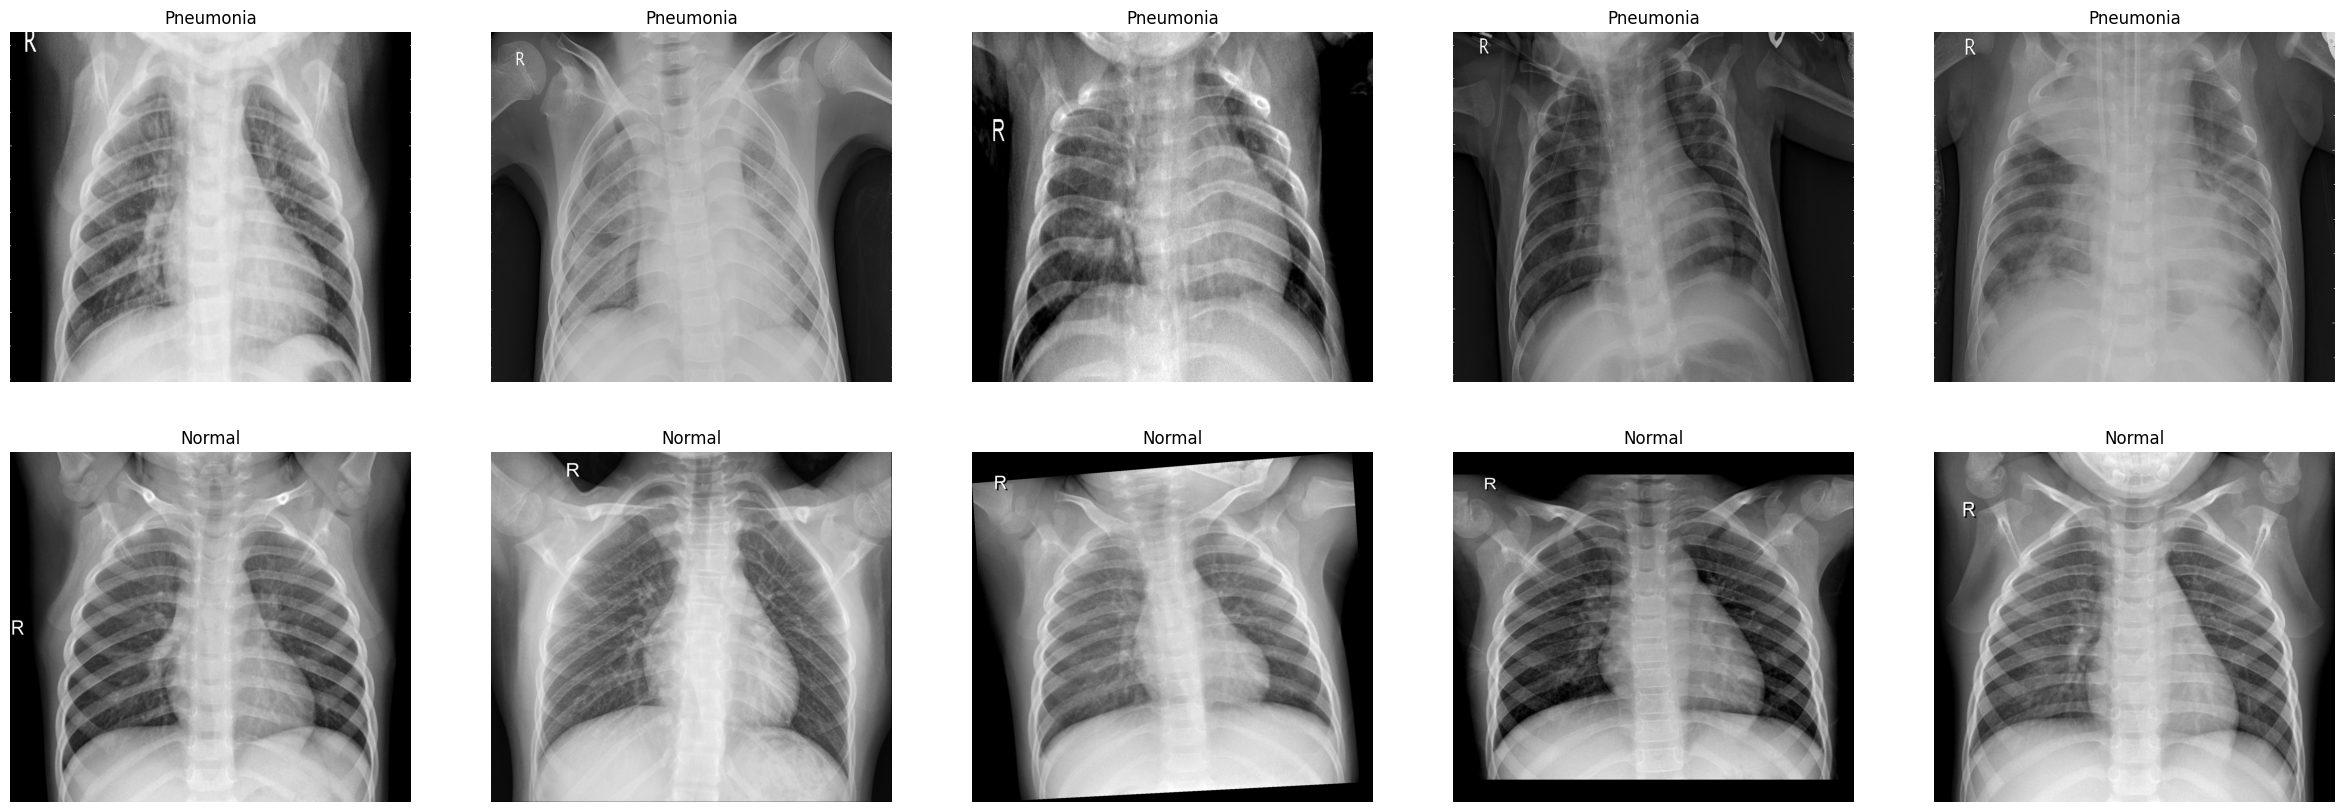

In [6]:
# Comparing the pictures:

# getting some samples:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
samples = pneumonia_samples + normal_samples    # concating the ata in a single list
# del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):     # for i in range(samples.length - 1):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Validation data preparation:

In [7]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# lists for validation images and their labels:
valid_data = []
valid_labels = []


# PROBLEM: some images are greyscale => I need to convert them into 3 channel images and then back to 1. Also, we need pixel normalization and rescaling (224x224)

# NORMAL
for img in normal_cases:
    img = cv2.imread(str(img))              # reading the image using its path
    img = cv2.resize(img, (224,224))        # resizing the image
    # we convert
    if img.shape[2] == 1:                    # if we have 1 channel, we convert it into 3 similar channels
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.           # translating into float and normalizing
    label = to_categorical(0, num_classes=2)    # getting binary class matrix (0 will be NORMAL cases)
    valid_data.append(img)
    valid_labels.append(label)

normal_length = valid_data.len()
print("Number of NORMAL cases: ", normal_length)

# PNEUMONIA        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)    # getting binary class matrix (1 will be PNEUMONIA cases)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Number of PNEUMONIA cases: ", valid_data.len() - normal_length)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


So, we have 16 pictures in validation dataset.

We can use AUGMENTATION to improve the precision of a model especially when the dataset is imbalanced. 

In [8]:
# Defining a augmentation sequence: 
seq = iaa.OneOf([       # it takes randomly one of the techniques below:
    iaa.Fliplr(),               # horizontal flips
    iaa.Affine(rotate=20),      # roatation
    iaa.Multiply((1.2, 1.5))])  # random brightness

Very simple data generator:

batch - part of data to train NN at once (reduce time-to-train)

In [9]:
def data_gen(data, batch_size):
    n = len(data)   # getting total number of samples in the data
    steps = n//batch_size   # getting number of steps based on batch_size
    
    # defining two numpy arrays for containing batch data and labels:
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Getting a numpy array of all the indices of the input data:
    indices = np.arange(n)  # = array([0,1,2,3,4,5,...,data_len])

    i = 0   # counter
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding:
            encoded_label = to_categorical(label, num_classes=2)
            # reading the image and resizing:
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class:
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

MODELLING

We will use simple architecture and do TRANSFER LEARNING for the first few layers with a network was pretrained on Imagenet (because first few layers capture general details like color blobs, patches, edges, etc.). => First two convolutional layers will have imagenet weights.

I found that SeparableConv is a good replacement for Conv layer since it takes less parameters. As different filters are applied to each channel, it captures more information.

Batch Norm layers - performs operations to standardize and normalize the input coming from the previous layer.  As the network becomes deeper, batch norm start to play an important role.  It applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

Dense layers: The best structure I found described below. We can experiment with the number of neurons, we can also increase depth.
Last layer has 2 neurons since it's **binary classification**.

We can also play with lowering learning rate and decay (a technique used in training neural networks that gradually reduces the learning rate over time).

In [10]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [11]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

Setting imagenet weights:

In [12]:
# Open the VGG16 weight file
f = h5py.File('./input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [13]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
#opt = Adam(lr=0.0001, decay=1e-5)


early_stopping = EarlyStopping(patience=5)      # patience is a number of epochs with no improvements
save_model_weights = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='Adam')

In [14]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


Training the model:

In [25]:
# # Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[early_stopping, save_model_weights],
                              class_weight={0:1.0, 1:0.4})

Epoch 1/20
326/326 [==============================] - 102s 311ms/step - loss: 0.0261 - accuracy: 0.9826 - val_loss: 1.7988 - val_accuracy: 0.7500
Epoch 2/20
326/326 [==============================] - 102s 314ms/step - loss: 0.0261 - accuracy: 0.9793 - val_loss: 1.0069 - val_accuracy: 0.8125
Epoch 3/20
326/326 [==============================] - 101s 311ms/step - loss: 0.0268 - accuracy: 0.9843 - val_loss: 4.3593 - val_accuracy: 0.7500
Epoch 4/20
326/326 [==============================] - 100s 308ms/step - loss: 0.0471 - accuracy: 0.9728 - val_loss: 1.6073 - val_accuracy: 0.7500
Epoch 5/20
326/326 [==============================] - 102s 312ms/step - loss: 0.0240 - accuracy: 0.9849 - val_loss: 0.1480 - val_accuracy: 0.9375
Epoch 6/20
326/326 [==============================] - 101s 309ms/step - loss: 0.0260 - accuracy: 0.9854 - val_loss: 3.8574 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 100s 307ms/step - loss: 0.0241 - accuracy: 0.9850 - val_loss: 0.6721 -

In [17]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [18]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 3s 60ms/step - loss: 1.3176 - accuracy: 0.7436
Loss on test set:  1.3176031112670898
Accuracy on test set:  0.7435897588729858


In [19]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


When a particular problem includes an imbalanced dataset, then accuracy isn't a good  metric to look for. For example, if your dataset contains 95 negatives and 5 positives, having a model with 95% accuracy doesn't make sense at all. The classifier might label every example as negative and still achieve 95% accuracy. Hence,  we need to look for alternative metrics. **Precision** and **Recall** are really good metrics for such kind of problems. 

We will get the confusion matrix from our predictions and see what is the recall and precision of our model.

In [20]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'alpha'

<Figure size 640x480 with 0 Axes>

In [21]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.72


Model has a 97% recall, a good recall value is expected. The precision is only 72% <= Precision and Recall follows a trade-off, and you need to find a point where your recall, as well as your precision, is more than good but both can't increase simultaneously. 

That's it folks!! I hope you enjoyed this kernel. Happy Kaggling!!

Recall 98% means that out of all actual positive your model correctly evaluated 98%. Precision of 79% means that's the percentage of actual positives out of the results your model predicted as positive. So the model is predicting as positive excessively right? Maybe it is even good to have higher recall that much in this case since the doctors want to be sure if the patient has the disease instead of saying false negative.


???

In [31]:
history.history['loss']

[0.026142427697777748,
 0.02609986625611782,
 0.02676382288336754,
 0.04708954319357872,
 0.02402750961482525,
 0.026039401069283485,
 0.024083949625492096,
 0.02592240460216999,
 0.04922785982489586,
 0.031815290451049805,
 0.02536146529018879,
 0.02951246313750744,
 0.018039945513010025,
 0.023288531228899956,
 0.030680246651172638]

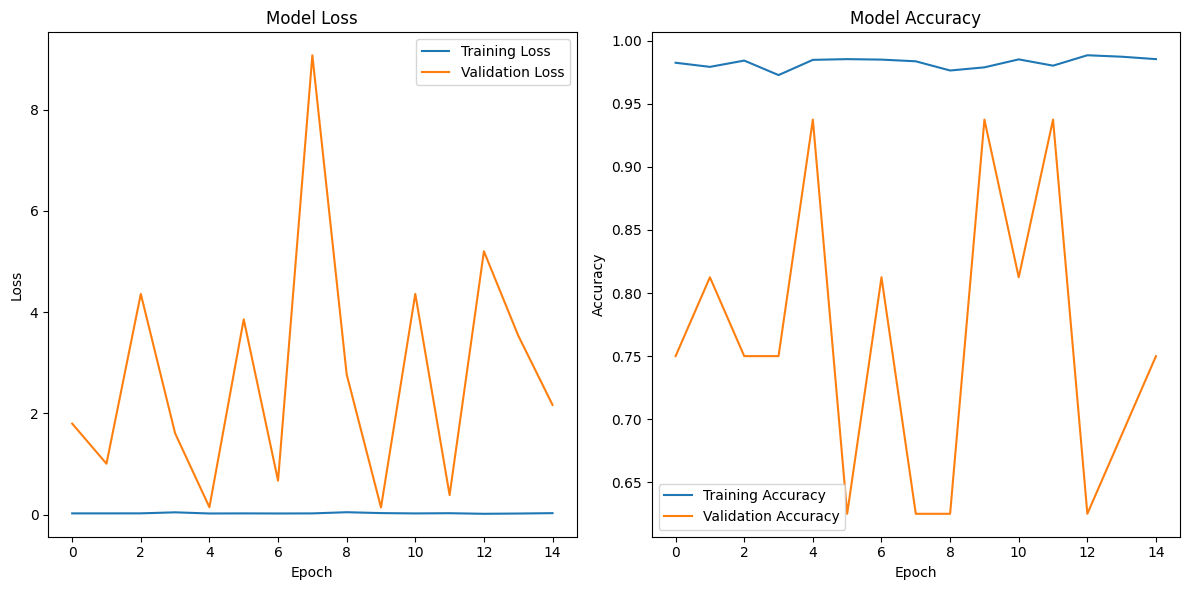

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


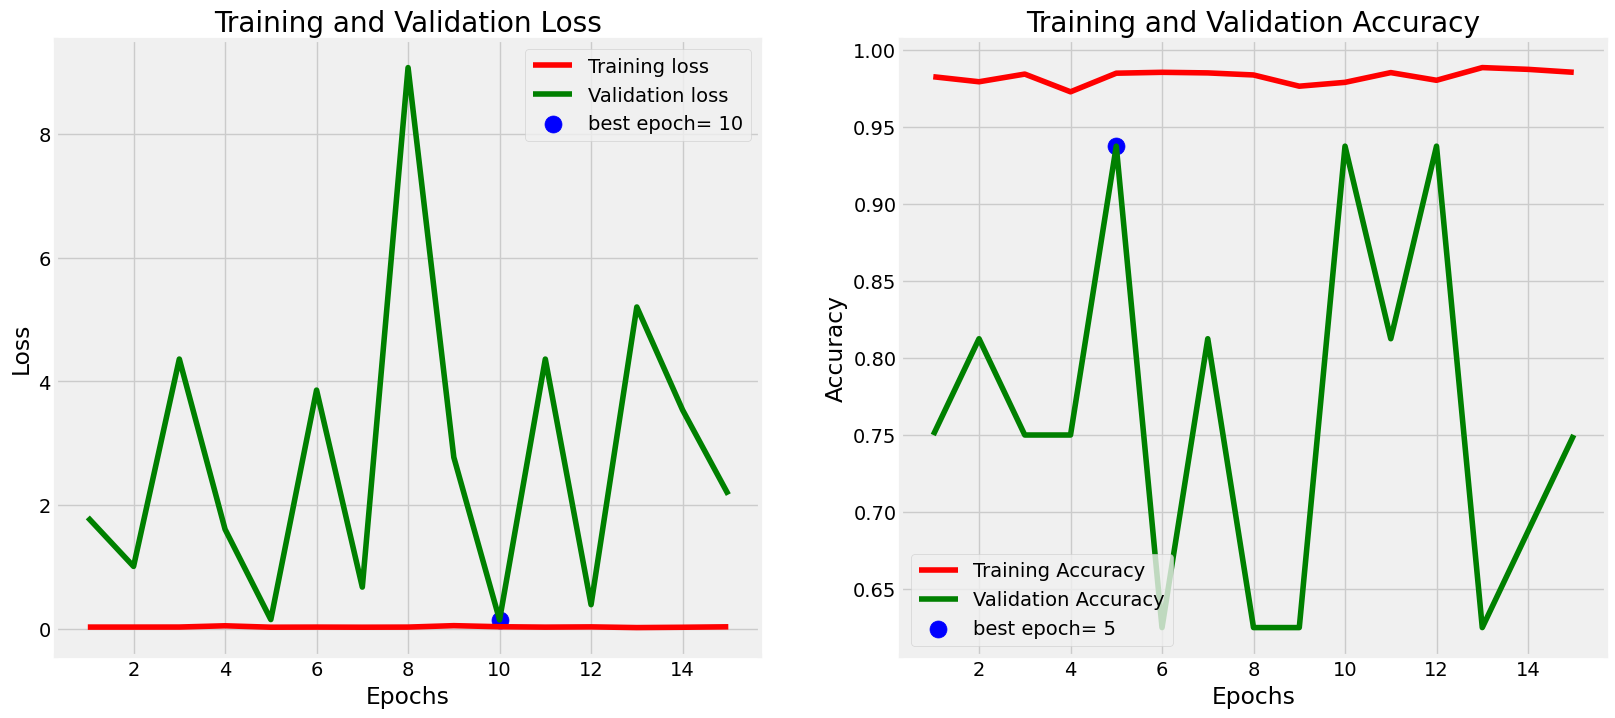

In [32]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()